# 深度学习基础

## tensor

### tensor 内部存储结构

#### 1、数据区域和元数据
PyTorch 中的 tensor 内部结构通常包含了数据区域(Storage)和元数据(Metadata) ：
- 数据区域 ： 存储了 tensor 的实际数据，且数据被保存为连续的数组。比如： a = torch.tensor([[1, 2, 3], [4, 5, 6]])，它的数据在存储区的保存形式为 [1, 2, 3, 4, 5, 6]
- 元数据 ：包含了 tensor 的一些描述性信息，比如 : 尺寸(Size)、步长(Stride)、数据类型(Data Type) 等信息

占用内存的主要是 数据区域，且取决于 tensor 中元素的个数， 而元数据占用内存较少。

采用这种 【数据区域 + 元数据】 的数据存储方式，主要是因为深度学习的数据动辄成千上万，数据量巨大，所以采取这样的存储方式以节省内存

<style>
    img{
        width: 80%;
        padding-left:5%;
    }
</style>

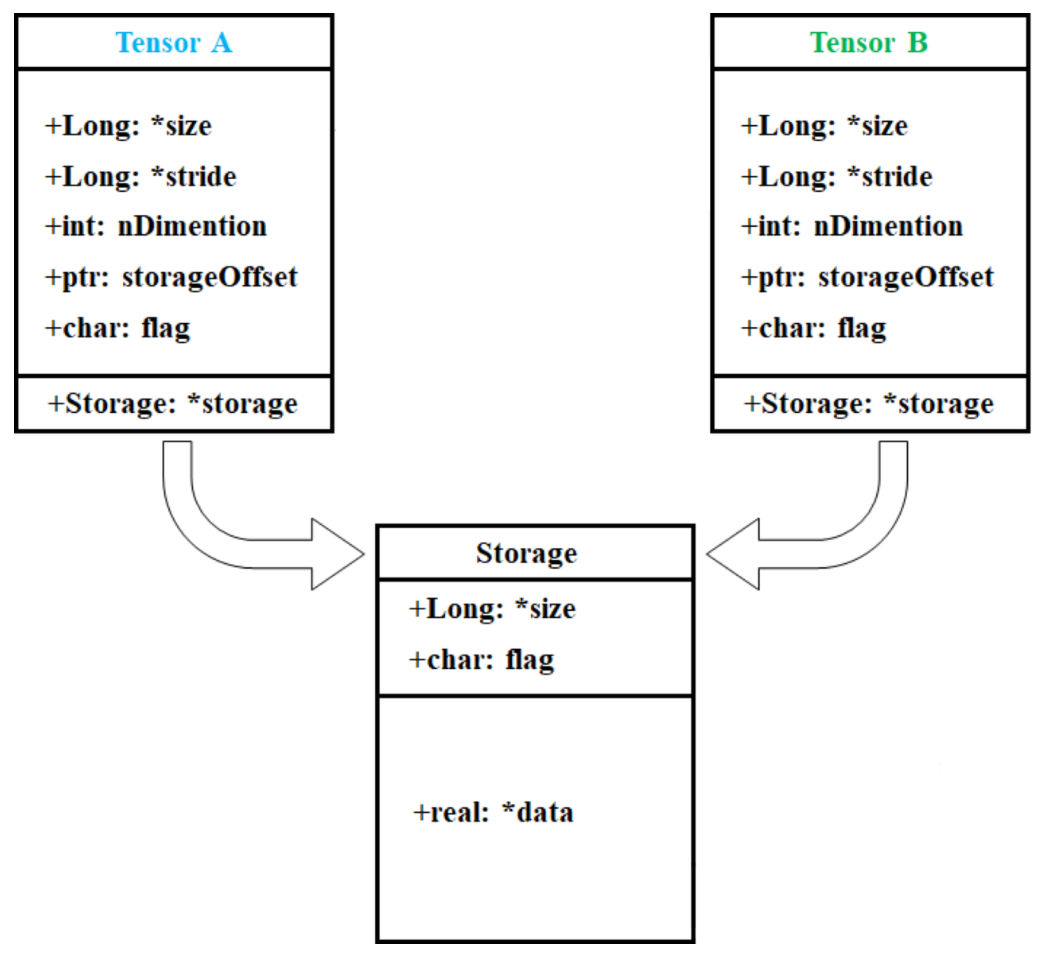

#### 2、查看 tensor 的存储区数据:  storage() 

** 虽然 .storage()  方法即将被弃用，而是改用 .untyped_storage()，但为了课件中展示方便，我们仍然使用 .storage() 方法。.untyped_storage() 方法的输出太长了，不方便截图放在课件中。

### tensor 的连续性 与 contiguous() 方法

#### 1、连续性

在 tensor 内部存储结构这篇，我们已经介绍了tensor 的数据存储结构，其中说到：Tensor多维数组 数据存储在存储区，底层实现是使用一块连续内存的 1维数数组 进行存储，而该多维数组的形状则保存在了 Tensor 的metadata 中， 例如 ：

```python
t = torch.arange(12).reshape(3,4)
```
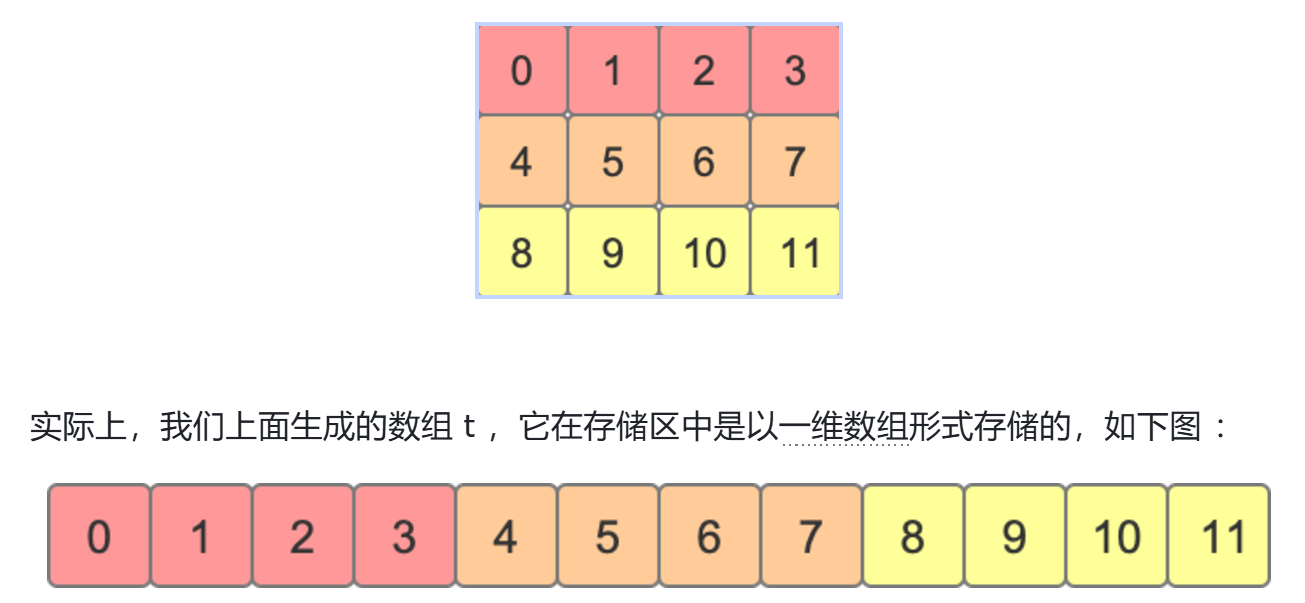

“连续性” 是指： Tensor底层一维数组元素的存储顺序 与Tensor按行优先一维展开的元素顺序是否一致。

我们可以通过 flatten() 方法查看 t 的一维展开形式，通过 storage()  方法查看数据存储区的元素

若 t 一维展开的元素顺序和 数据存储区的元素顺序一致，就说明： t 是连续的

```python
import torch

t = torch.arange(12).reshape(3,4)

print(t.flatten())
print(t.storage())
```



#### 2、不连续 举例

```python
import torch

t = torch.arange(12).reshape(3,4)
print(t)

t2 = t.transpose(0, 1)  # 对 t 进行转置
print(t2)

print(t2.flatten())
print(t2.storage())
```

输出：

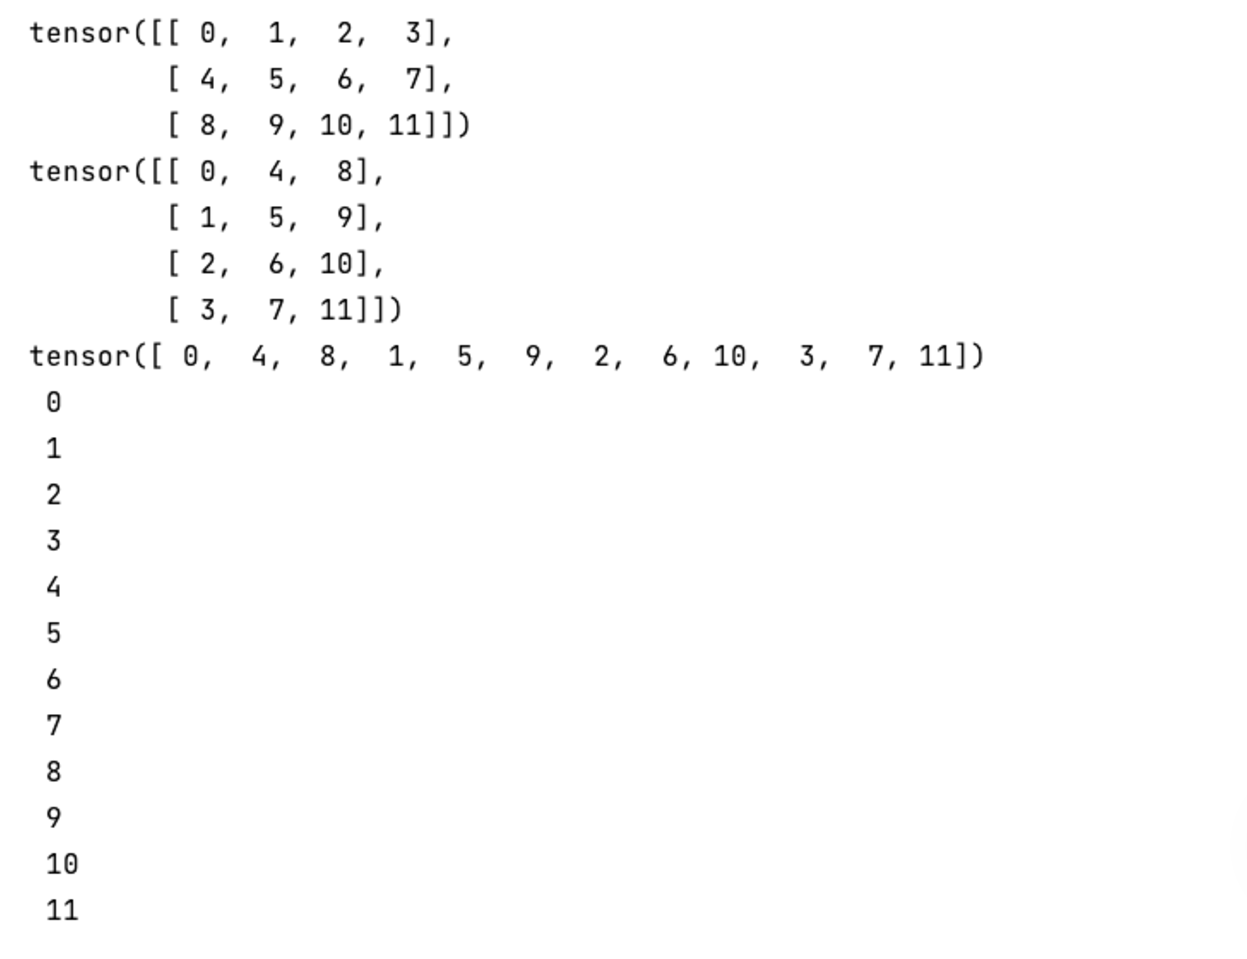

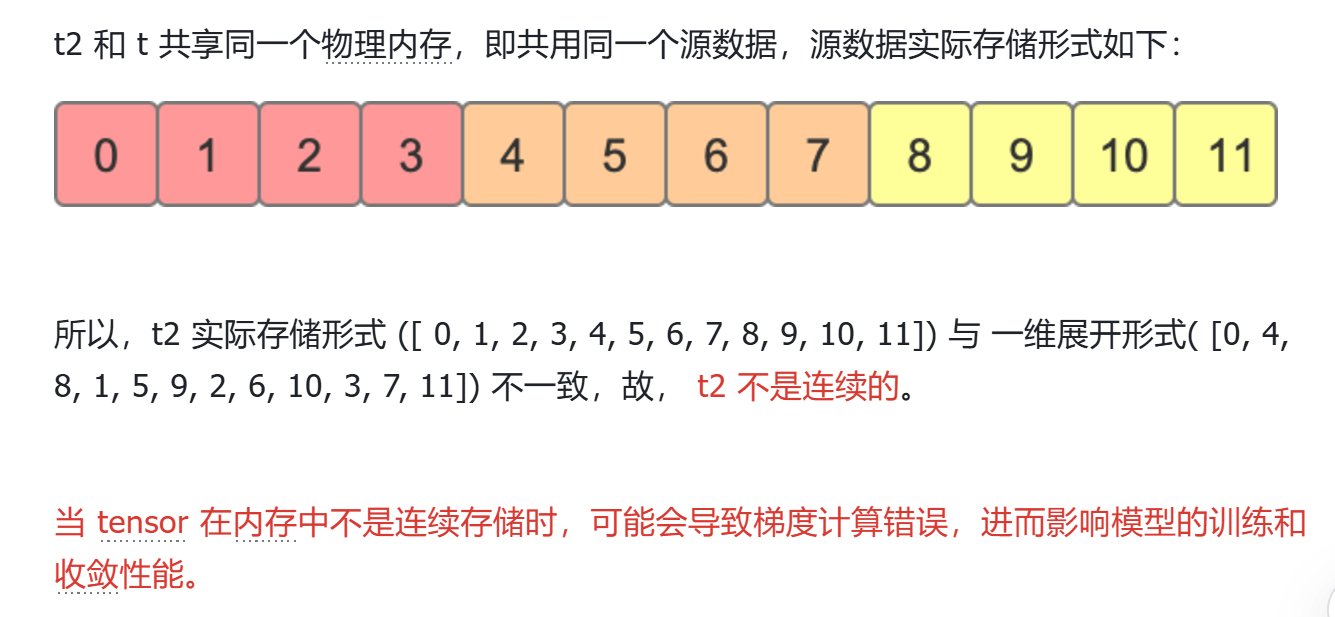

### 3、is_contiguous() 方法、contiguous()方法

- 首先，你可通过 is_contiguous() 来判断 Tensor 是否连续

```python
import torch

t = torch.arange(12).reshape(3,4)
t2 = t.transpose(0, 1)
print(t2.is_contiguous())  # False
```

- 其次，你可以在不知道 Tensor 是否连续的情况下，直接使用 contiguous()方法，使其变得连续，但在不同的情况下， contiguous() 的操作是不一样的：
  - 如果Tensor 不是连续的，则会重新开辟一块内存空间保证数据是在内存中是连续的
  - 如果Tensor 是连续的，则 contiguous() 无操作

```python
import torch

t = torch.arange(12).reshape(3, 4)
t2 = t.transpose(0, 1)
print(t2)

t3 = t2.contiguous()
print(t3)

print(t3.data_ptr() == t2.data_ptr())    
```

对 t2 使用 contiguous() 方法，生成 t3，t3 和 t2 是完全不同的tensor （不是使用同一个存储区的源数据）

### 4、view 与 reshape 对 tensor 连续性的要求

（1）view

在使用 view前，要保证 tensor 的连续性，否则会报错

```python
import torch

t = torch.arange(12).reshape(3, 4)
t2 = t.transpose(0, 1)
print(t2)

t3 = t2.view(2, 6)
print(t3)
```

所以，如果 tensor 不连续，我们要先通过 contiguous() 方法，将数据转换为连续的tensor，再使用 view

```python
import torch

t = torch.arange(12).reshape(3, 4)
t2 = t.transpose(0, 1)
print(t2)

t3 = t2.contiguous()
t3 = t3.view(2, 6)
print(t3)
```

（2）reshape

为了解决用户使用便捷性问题，PyTorch 在0.4版本以后提供了reshape方法，实现了类似于 tensor.contigous().view(*args) 的功能，如果不关心底层数据是否使用了新的内存，则使用 reshape方法 更方便。

```python
import torch

t = torch.arange(12).reshape(3, 4)
t2 = t.transpose(0, 1)
print(t2)

t3 = t2.reshape(2, 6)
print(t3)
```

## Dataset and Dataloader

- Dataset作用：
  - 定义和管理如何获取单个数据样本及其标签
  - 包含 加载数据/读取数据、预处理数据、图像增强 等一系列操作
  - 返回 单个数据样本 的处理结果
- DataLoader  作用 ：
  - 指定数据读取规则，一般通过 sampler 指定
  - 指定 batch数据的打包规则，通过 collate_fn 指定
  - 每次迭代，返回的是 一个batch 的数据

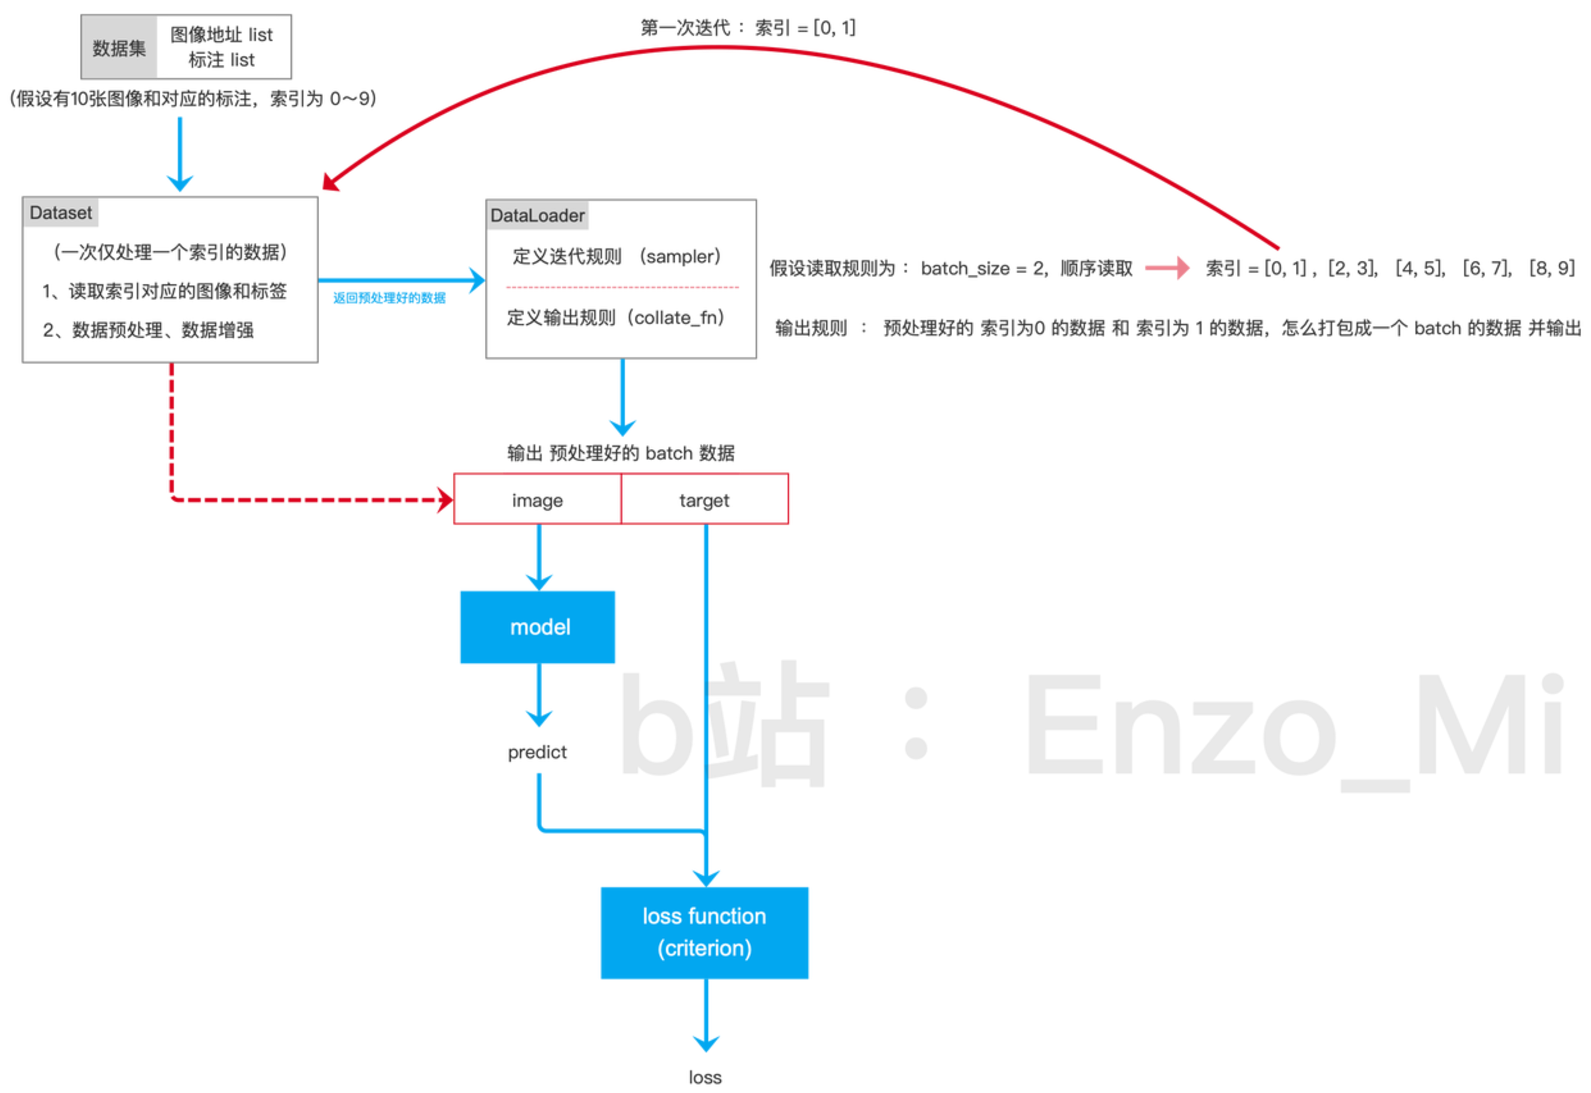

### 生成 Dataset 方式一 ：自定义Dataset

所谓的 自定义 dataset ，即：我们自己去写一个 Dataset 类 ：

- 一般需要继承  torch.utils.data.Dataset 
  - 继承 torch.utils.data.Dataset  主要是为了与 DataLoader 保持兼容，确保数据集遵循 DataLoader 的接口标准，方便后续使用 PyTorch 提供的工具，比如 ：批量加载、打乱数据、并行处理等功能
- 并且满足和 DataLoader 进行交互的规范 ：
  - DataLoader 会调用 Dataset 的 len() 和 getitem() 方法，所以自定义 Dataset 类必须实现这两个方法，如此才能保证 DataLoader 可以正确地加载和操作你的数据集

#### 1、自定义 Dataset 的三个重要方法

创建自定义 Dataset 时，必须实现的3个方法 ：__init__()、__len__()、 __getitem__()。

这些方法定义了数据集的基本结构和行为，也是 DataLoader 可以正确的从 Dataset 中读取数据的基础。

- init 方法
  - 参数： 根据需要传递一些参数，例如文件路径、数据转换等。
  - 作用： 可以在这里进行一些初始化工作，例如：设置文件路径、定义数据转换transforms 等。
  
  ```python
  def __init__(self, data_folder, train, transform=None):
      self.data_folder = data_folder
      self.transform = transform
      self.file_list = os.listdir(data_folder)
      self.train = train
  ```

- len 方法
  - 返回值： 需返回数据集中的样本的总数。
  - 作用： 
    - 方便通过调用 `len(dataset)` 来获取数据量，其中 dataset 为 Dataset 对象
    - Dataloader 会用它 和 batch_size 一起来计算一个epoch 要迭代多少个 steps： $$steps = \frac{len(dataset)}{batchsize}$$

  ```python
  def __len__(self):
    return len(self.file_list)
  ```
  
  
- getitem 方法
  ```python
  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.file_list[idx])
    original_image = Image.open(img_name)
    label = img_name.split('_')[-1].split('.')[0]

    if self.train:
        image = self.transform(original_image)
    else:
        image = self.transform(original_image)

    return image, label
  ```
  - 参数： index 是样本的索引。
  - 返回值： 返回数据集中索引指定的样本。通常是一个包含输入数据和对应标签的元组。这里可以根据自己的需求，进行自定义。
  - 作用： 根据给定的索引返回数据集中的一个样本。这是用于获取数据集中单个样本的方法。
    
    比如，可以通过 dataset[0] 来获取 dataset 中的索引为 0 的样本
  

#### 2、使用举例
用 CIRFAR-100 数据集生成 Dataset

<style>
    img{
        width: 100%;
        padding-left: 0%;
    }
</style>

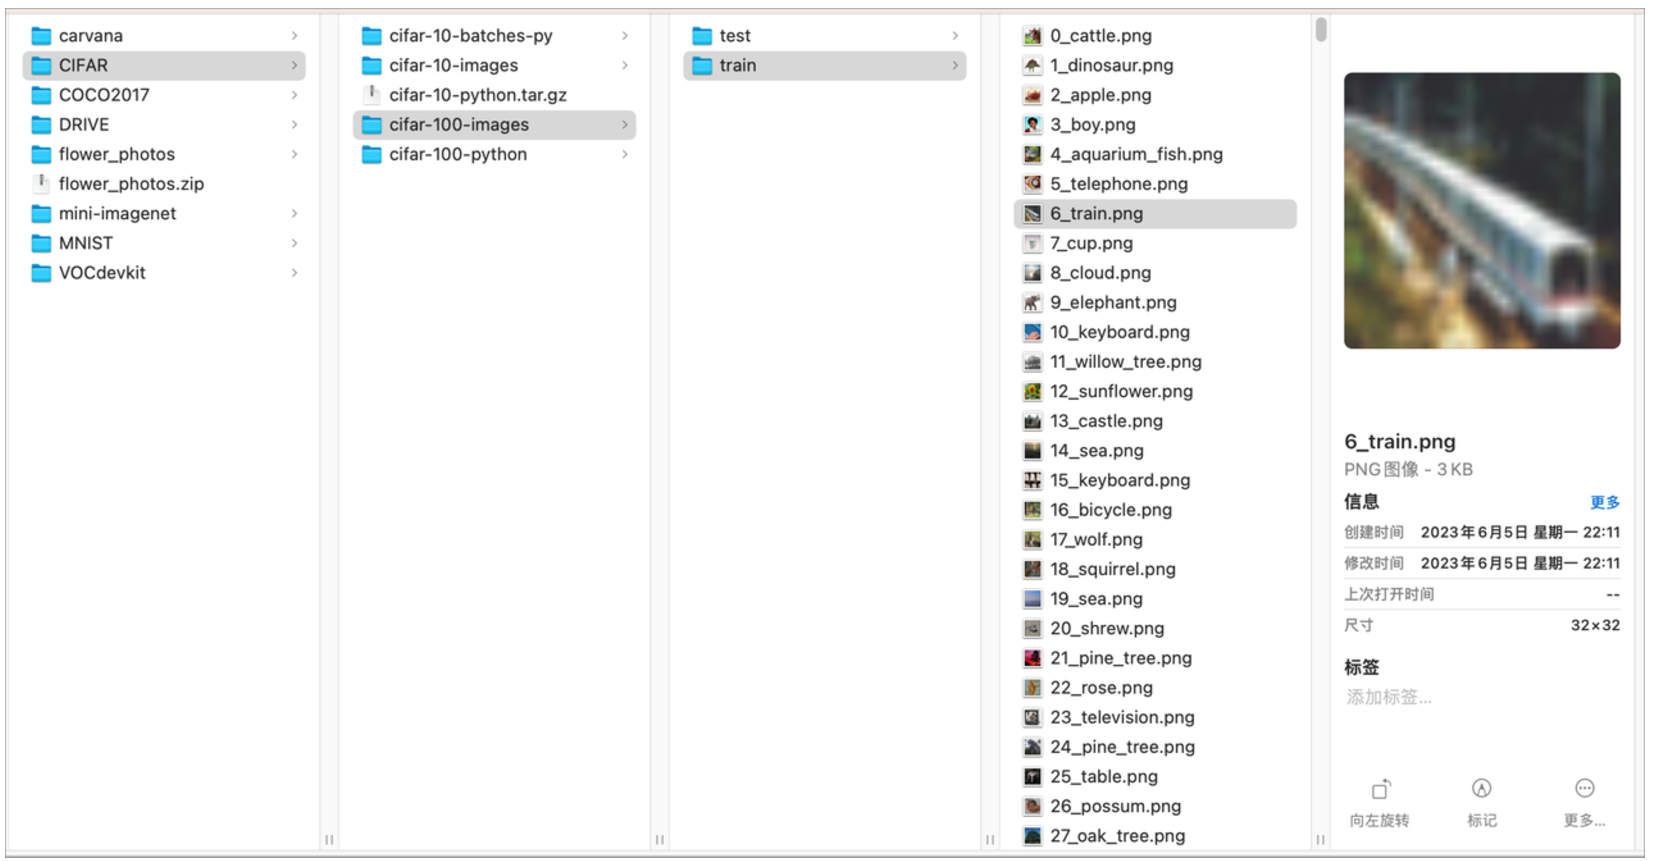



```python
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


class CustomDataset(Dataset):
    def __init__(self, data_folder, train, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.file_list = os.listdir(data_folder)
        self.train = train

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.file_list[idx])
        original_image = Image.open(img_name)
        label = img_name.split('_')[-1].split('.')[0]

        if self.train:
            image = self.transform(original_image)
        else:
            image = self.transform(original_image)

        return image, label

    def __len__(self):
        return len(self.file_list)


images_dir = "/Users/enzo/Documents/GitHub/dataset/CIFAR/cifar-100-images/train"
dataset = CustomDataset(images_dir, train=True, transform=transforms.ToTensor())

print(len(dataset))

# 通过 dataset 对象，获取索引为 0 的样本
sample_image, sample_label = dataset[0]
print("Sample Image Shape:", sample_image.shape)
print("Sample Label:", sample_label)
```

**输出**

<style>
    img {
        width: 60%;
        padding-left: 5%;
    }
</style>


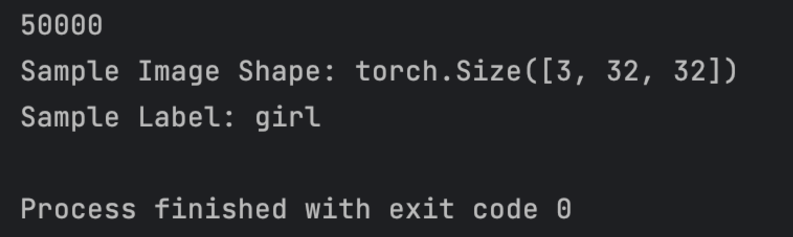

### 生成 Dataset 方式二 ：torchvision.datasets 模块

#### 1、pytorch 官方支持下载的数据集

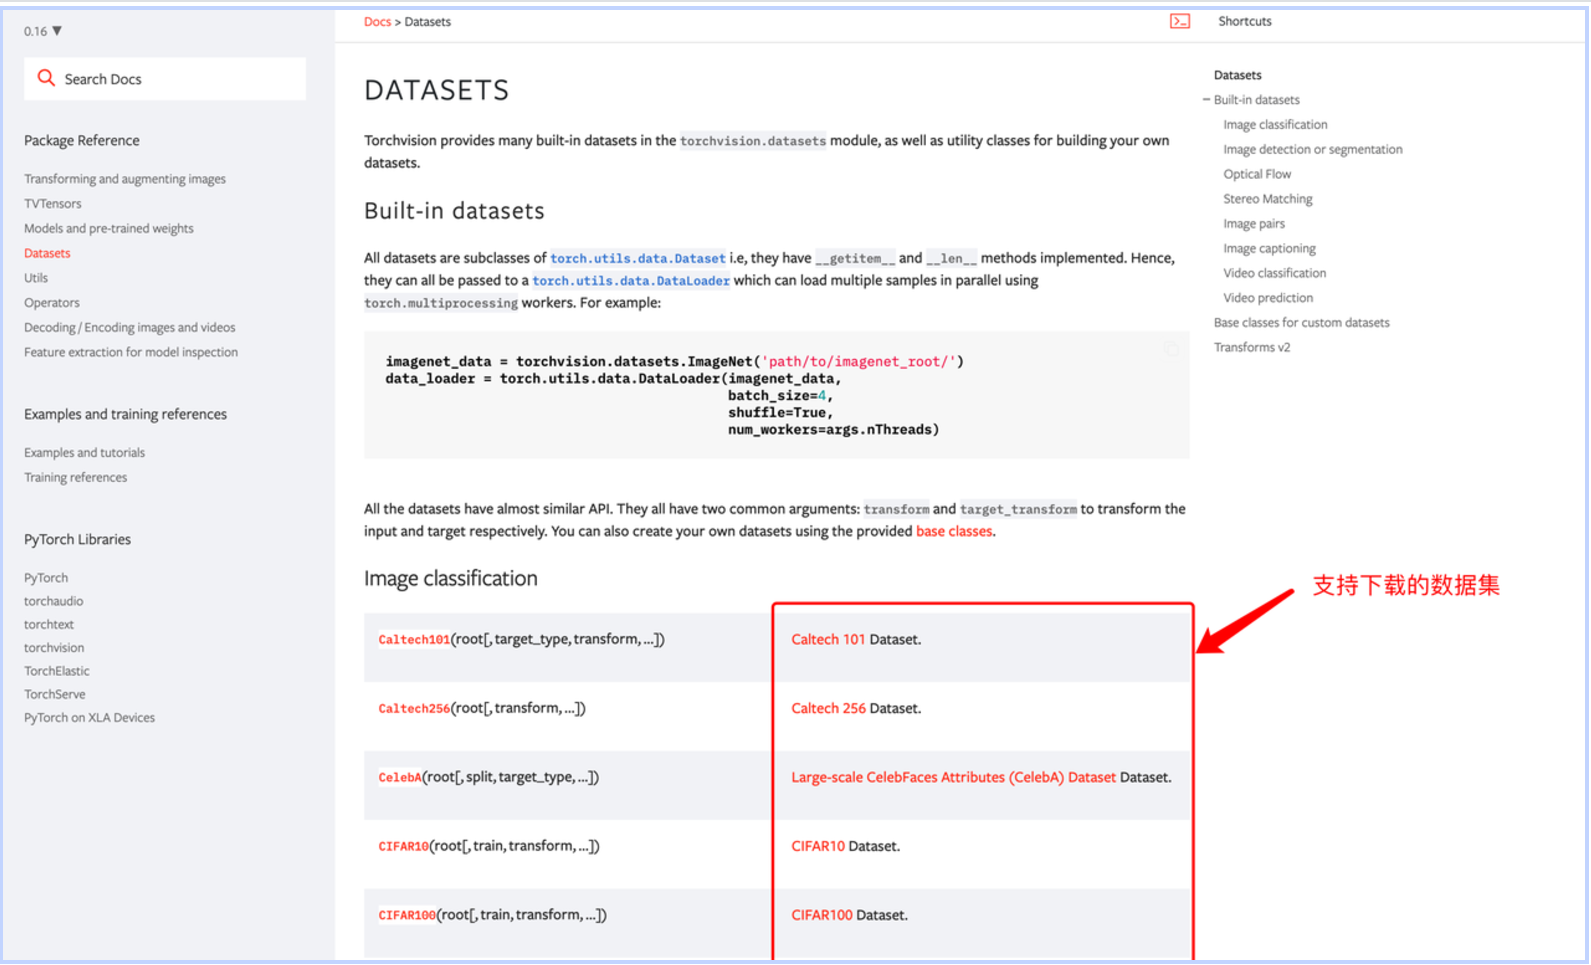

注 ：
  - 对于一部分数据集，提供下载功能
  - 对于一部分数据集，不提供下载功能 （具体情况取决于数据集的来源和许可协议）

#### 2、torchvision.datasets 模块

  以获取 MNIST 数据集为例  （pytorch官方文档地址 ： 点击查看）

  MNIST  全称：mixed national institute of standards and technology database

```python
train_dataset = torchvision.datasets.MNIST(root,    
                                           train=True,               
                                           transform=None,  
                                           target_transform= None  
                                           download=True)
```

  参数 ：
  - root ：数据集存放的路径
  - train：如果是True, 下载训练集 trainin.pt； 如果是False，下载测试集 test.pt。  默认是True
  - transform：一系列作用在PIL图片上的转换操作
  - download：是否下载数据集，默认为 False
    - 若设置 download=True
      - root 目录下没有该数据集，数据集将会被下载到 root 指定的位置。
      - root 目录下已经存在该数据集，则不会重新下载，而是会直接使用已存在的数据，以节省时间
    - 若设置 download=False，程序将会在 root 指定的位置查找数据集，如果数据集不存在，则会抛出错误。

#### 3、举例 1：torchvision.datasets.MNIST
  - 因为是单通道，所以 transforms.Normalize 的均值和标准差 仅指定了一个值
  - 记得把数据集的下载地址换掉，换成你想要它下载到的位置
  
```python
import torchvision
from torchvision.transforms import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt

batch_size = 5

my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5],  # mean=[0.485, 0.456, 0.406]
                                                        std=[0.5])])  # std=[0.229, 0.224, 0.225]

train_dataset = torchvision.datasets.MNIST(root="./",
                                           train=True,
                                           transform=my_transform,
                                           download=True)

val_dataset = torchvision.datasets.MNIST(root="./",
                                         train=False,
                                         transform=my_transform,
                                         download=True)

train_loader = data.DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

val_loader = data.DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=True)

print(len(train_dataset))
print(len(val_dataset))

image, label = next(iter(train_loader))
print(image.shape)
print(label)

for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.title(label[i].item())
    plt.axis("off")
    plt.imshow(image[i].permute(1, 2, 0))

plt.show()
```

<style>
    img{
        width: 70%;
        padding-left: 10%;
    }
</style>

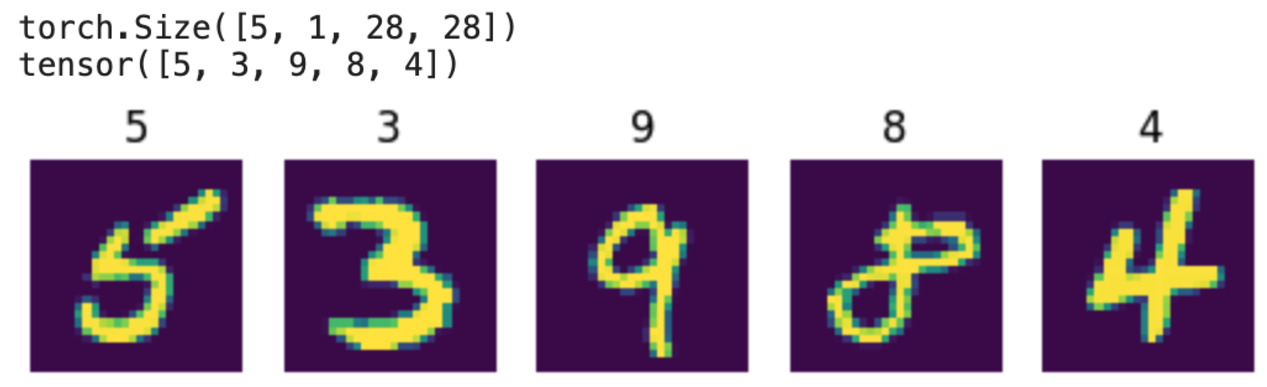

#### 4、举例 2：torchvision.datasets.CocoDetection 

torchvision.datasets.CocoDetection 不支持 COCO 数据集下载

在使用 torchvision.datasets.CocoDetection 之前，需要确保已经下载并淮备好COCO数据集的图像和标注文件。然后使用 torchvision.datasets.CocoDetection 类来加载 COCO数据集。

```python
torchvision.datasets.CocoDetection(root, 
                                   annFile, 
                                   transform=None, 
                                   target_transform=None, 
                                   transforms=None)
```

参数 ：
  - root  :  指定图片地址 （本地已经下载下来的图像地址）
  - annFile  :  指定标注文件地址（ 本地已经下载下来的标注文件地址）
  - transform  :  图像处理 (用于PIL)
  - target_transform  :  标注处理
  - transforms  :  图像和标注的处理

使用举例：
- 记得把数据集的下载地址换掉，换成你的 COCO数据集地址

```python
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms import functional as F
import random


def collate_fn_coco(batch):
    return tuple(zip(*batch))

coco_det = datasets.CocoDetection(root="./COCO2017/train2017",
                                  annFile="./COCO2017/annotations/instances_train 2017.json")


sampler = torch.utils.data.SequentialSampler(coco_det)  # RandomSampler
batch_sampler = torch.utils.data.BatchSampler(sampler, 1, drop_last=True)
data_loader = torch.utils.data.DataLoader(coco_det,
                                          batch_sampler=batch_sampler,
                                          collate_fn=collate_fn_coco)

# 可视化
iterator = iter(data_loader)
imgs, gts = next(iterator)
img,  gts_one_img = imgs[0], gts[0]

bboxes = []
ids = []
for gt in gts_one_img:
    bboxes.append([gt['bbox'][0],
                   gt['bbox'][1],
                   gt['bbox'][2],
                   gt['bbox'][3]
                   ])
    ids.append(gt['category_id'])

fig, ax = plt.subplots()
for box, id in zip(bboxes, ids):
    x = int(box[0])
    y = int(box[1])
    w = int(box[2])
    h = int(box[3])
    rect = plt.Rectangle((x, y), w, h, edgecolor='r', linewidth=2, facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, id, backgroundcolor="r")

plt.axis("off")
plt.imshow(img)
plt.show()
```

<style>
    img {
        width: 66%;
        padding-left: 10%;
    }
</style>

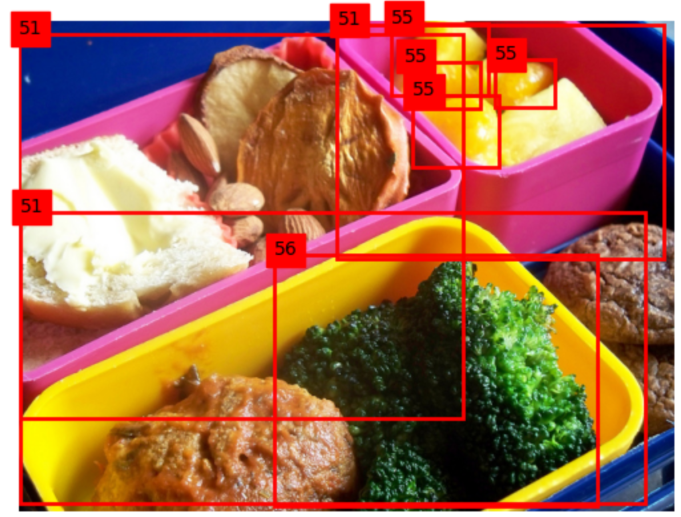

### DataLoader

#### 1、torch.utils.data.DataLoader

```python
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, 
                         batch_size=1, 
                         shuffle=None, 
                         sampler=None, 
                         batch_sampler=None, 
                         num_workers=0, 
                         collate_fn=None, 
                         pin_memory=False, 
                         drop_last=False,
                         timeout=0
                         )
```

参数：
  - dataset ： 加载数据的数据集
  - batch size ： 每批返回的数据量，默认值是 1
  - shuffle：是否在每个 epoch 内将数据打乱顺序。默认值为False
  - sampler ：从数据集中提取的样本序列。可以用来自定义样本的采样策路。默认值为None
  - batch_sampler ：与sampler类似，但是一次返回一个 batch的索引，用于自定义 batch。它与batch size、shuffle、sampler 和 drop last 互斥
  - num workers : 用于数据加载的子进程数。0表示主进程加载。默认值为0
  - collate_fn: 用于指定如何组合样本数据。如果为None，那么将默认使用默认的组合方法
  - drop_last : 如果数据集的大小不能被 batch _size 整除，那么是否丢弃最后一个数据批次。默认值为 False
  - pin_memory : 将数据固定在内存的锁页内存中，加速数据读取的速度。默认值为False.
  - timeout : workers ：等待 collect 一个 batch 的数据的超时时间。默认为 0，表示一直等待

#### 2、常用参数图示

dataset 对 Dataloader 有 2个作用 ：
- 通过 dataset 的 length 方法，dataloader 可以知道数据量，从而根据数据量生成相应的索引列表
- dataloader 会将索引，传给 dataset 的 getitem 方法，通过 getitem 方法对数据进行处理，并返回处理好的数据

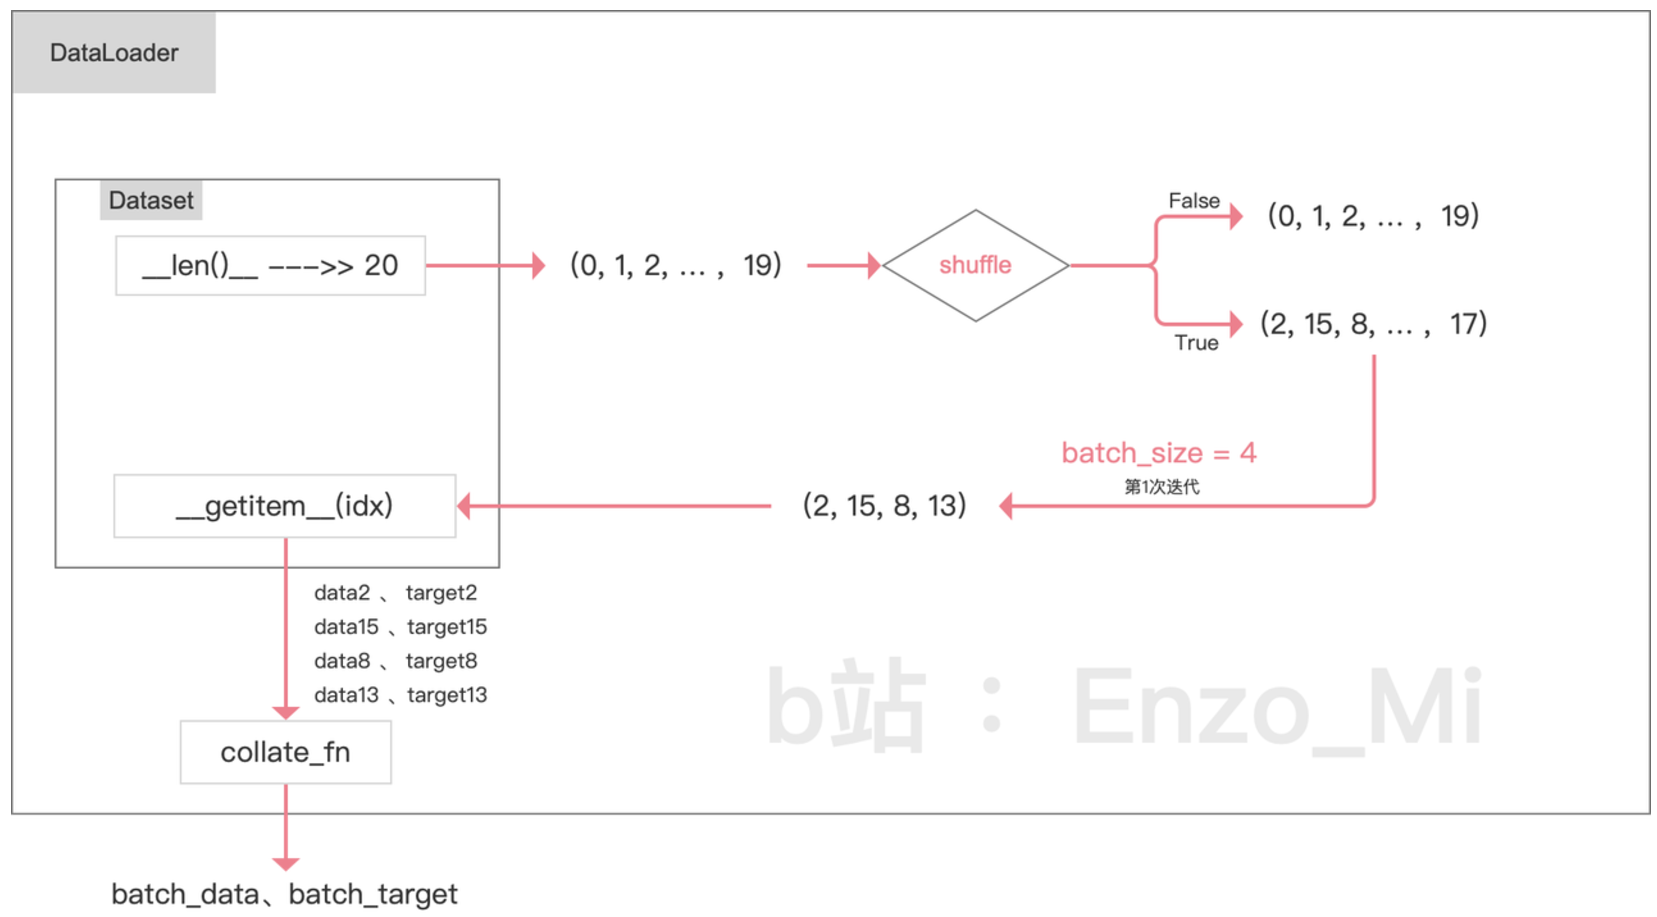

#### 3、Dataset 与 Dataloader 的内部交互细节 举例

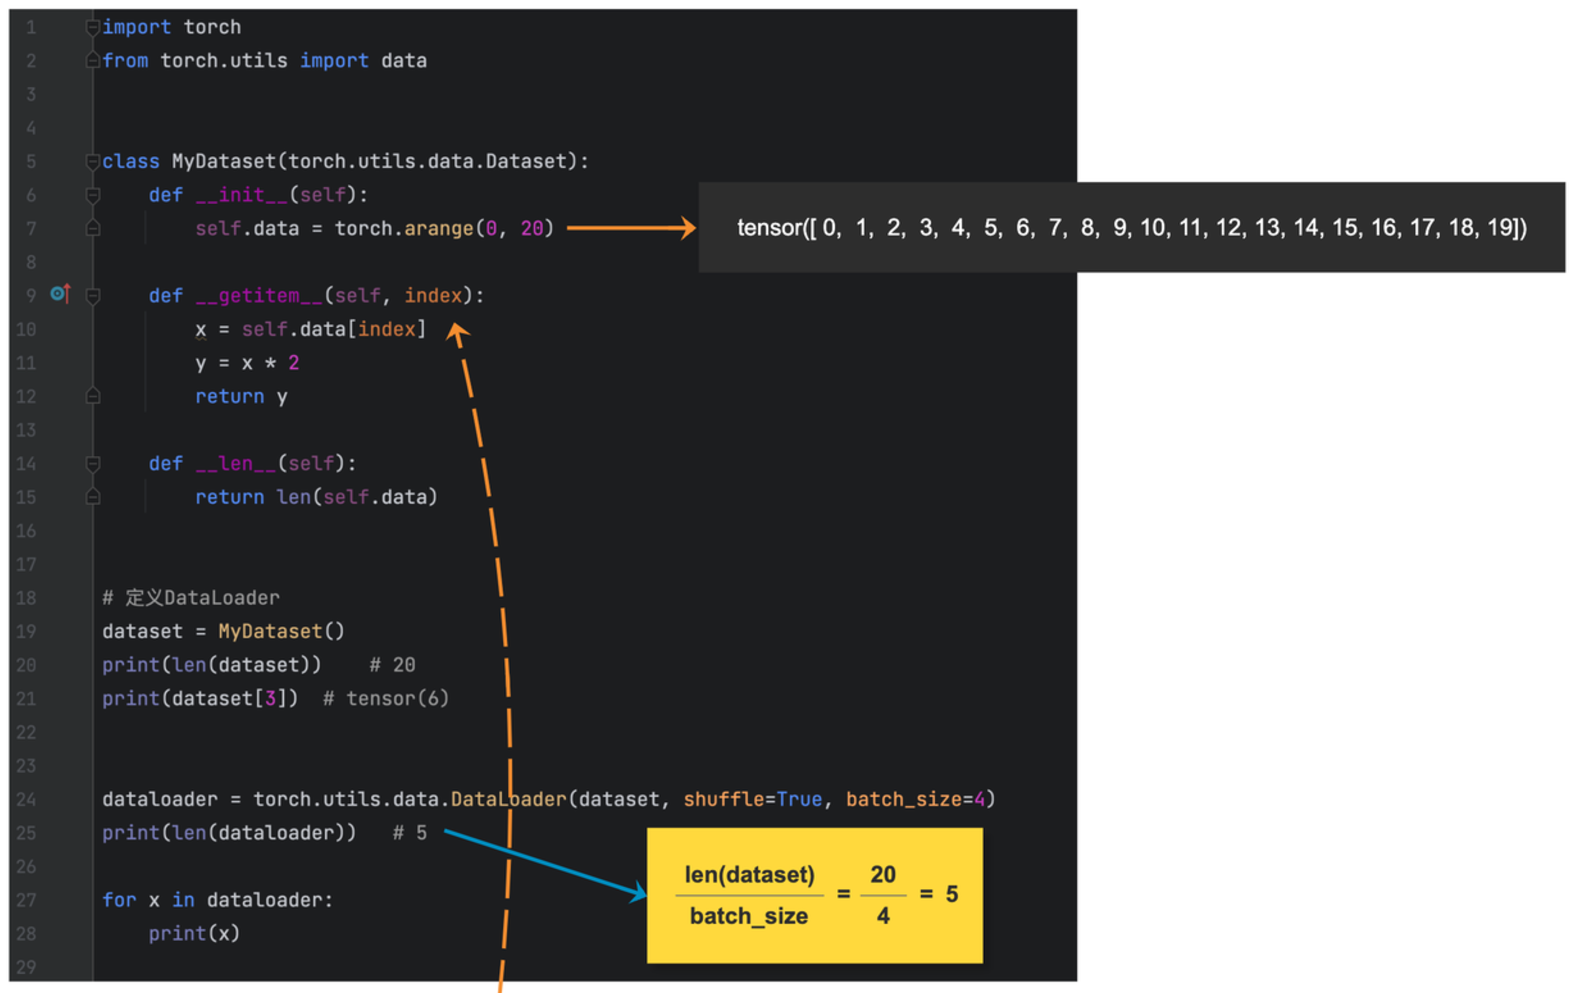

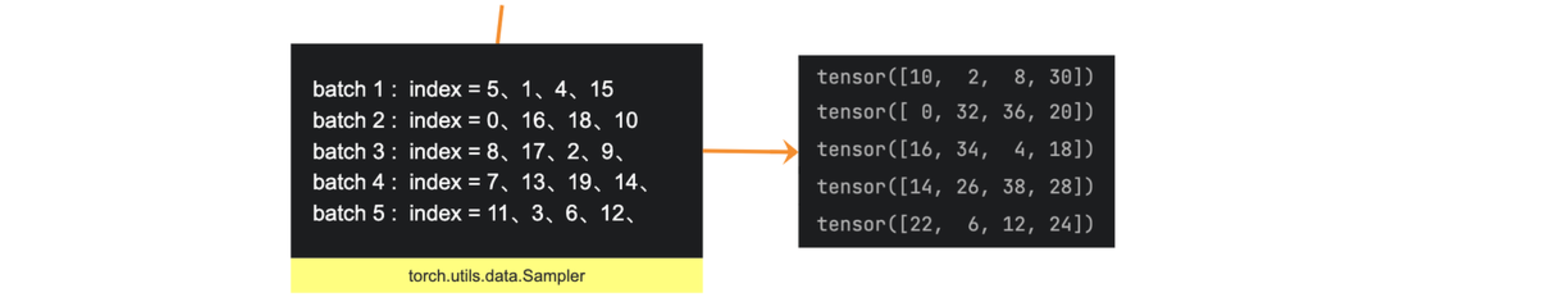

#### num_workers与pin_memory

##### 1、参数 num_workers 
参数 num_workers 参数用于指定 加载数据的子进程的数量
- num_workers=0 ：(默认值) 表示只有主进程去加载 batch数据，这个可能会是一个瓶颈。
- num_workers=1 ：表示只有一个子进程加载数据，主进程不参与，这仍可能导致速度慢。
- num_workers>0 ：表示指定数量的子进程并行加载数据，且主进程不参与。
增加num_workers可以提高加载速度，但也会增加 CPU 和 内存的使用。

通常建议将 num_workers 参数设置为等于或小于 CPU 核心数，以有效平衡数据加载效率和系统资源占用率。

进程之间是动态调度的


```python
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])   # number of workers
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw,
                                               shuffle=True,
                                               pin_memory=True,
                                               collate_fn=collate_fn)
```

##### 2、数据加载过程是如何并行的
> 一个进程处理一个 batch 的数据，假设设置 num_workers=2 ，则 进程1 处理一个batch 的数据，进程2 处理另一个batch 的数据

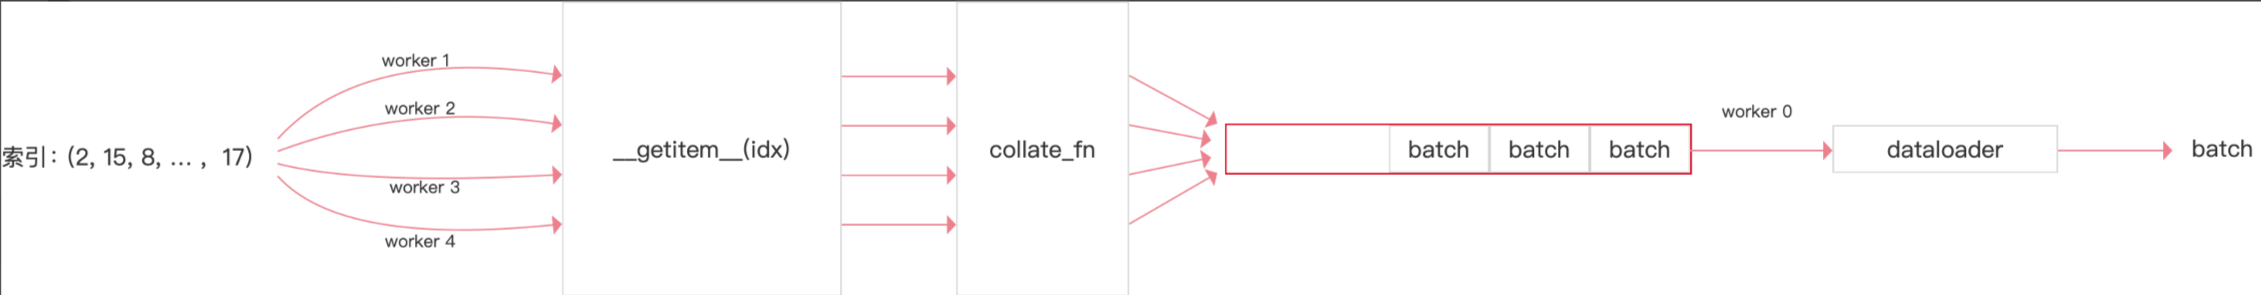


并行工作流程 ：
- 初始化：创建 DataLoader 实例时，通过参数 num_workers 指定并行加载的子进程数量
- 子进程加载数据：子进程独立于主进程运行，每个子进程的拿着一个batch 的索引，并行的到 dataset 的 getitem 中预处理数据
- 数据准备：处理好的数据，放入缓冲区以备主进程请求
- 数据请求：主进程在 for 循环中请求下一个 batch
- 数据传输：主进程请求数据时，从缓冲区获取已经准备好的 batch
- 循环迭代：主进程不断请求数据，子进程并行的处理后续的 batch 数据

##### 3、pin_memory 
- 若设置 pin_memory=True，数据会被加载到CPU的锁定内存中，从而提高数据从 CPU 到 GPU 的传输效率
  
    这是因为锁定的内存（pinned memory）可以更快地被复制到GPU，因为它是连续的，并且已经准备好被传输。

- 若设置 `pin_memory=False` ，则数据是被存放在分页内存（pageable memory）中，当我们想要把数据从 cpu 移动到 gpu 上 （执行 `.to('cuda')` 的时候）， 需要先将数据从分页内存中 移动到锁页内存中，然后再传输到 GPU 上
    
    所以，设置 `pin_memory=True` ，节省的是 将数据从 分页内存移动到锁页内存中 的这段时间

如果你的训练完全在CPU上进行，不涉及GPU，那就没有必要设置`pin_memory=True`。因为在这种情况下，数据不需要被传输到GPU，因此不需要使用锁定内存来加速这一过程。可以将 `pin_memory` 设置为 `False`，以简化内存管理

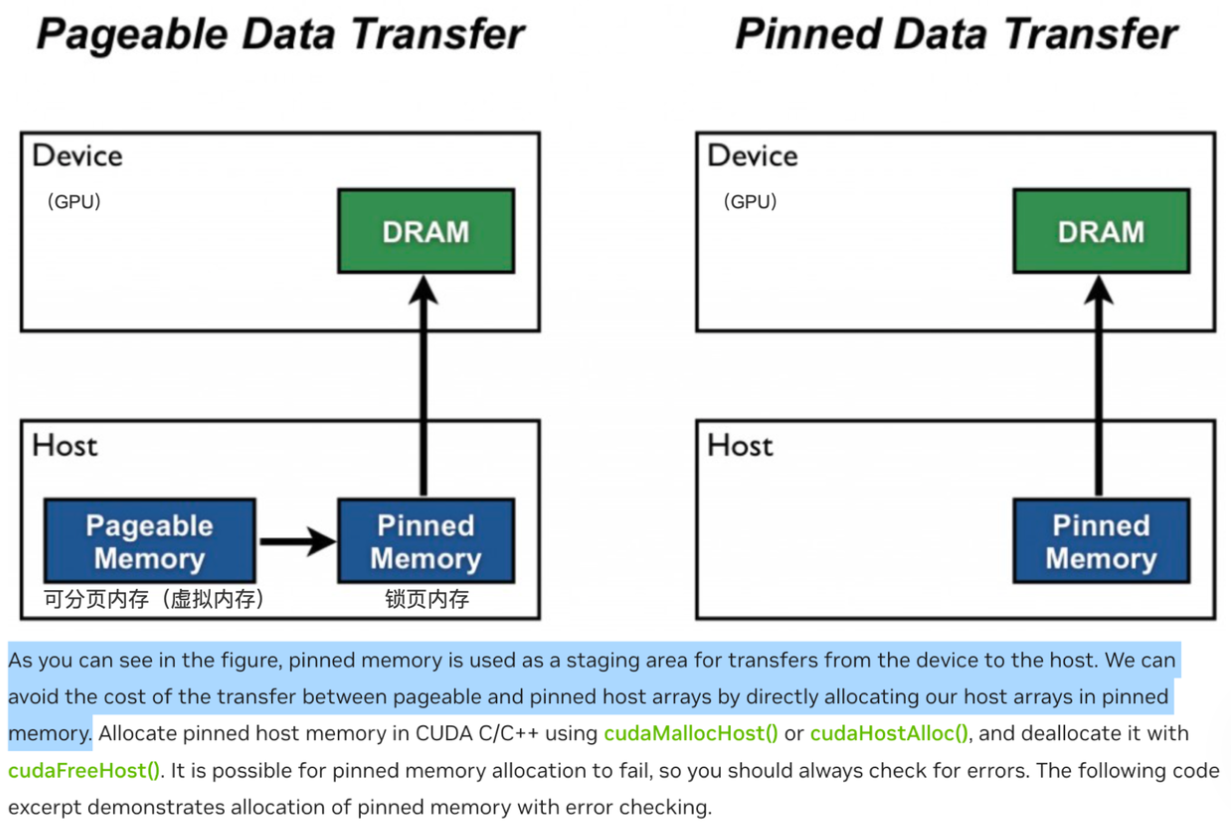

#### sampler与batch_sampler

##### 1、sampler

torch.utils.data.DataLoader 的参数 sampler 接收的通常是一个实现了 Sampler 接口的对象，比如 ：

```python
sampler = SequentialSampler(dataset)   # 使用 SequentialSampler
dataloader = DataLoader(dataset, batch_size=8, sampler=sampler)
```

通过 sampler 对象来控制数据集的索引顺序，从而影响数据从数据集中的抽取方式

1）pytorch 提供的，可以直接使用的几种  sampler

```python
# 顺序抽样，按照数据集的顺序逐个抽取样本
torch.utils.data.sampler.SequentialSampler()

# 随机抽样，数据集中的样本以随机顺序被抽取
torch.utils.data.sampler.RandomSampler()

# 从指定的样本索引子集内进行随机抽样
torch.utils.data.sampler.SubsetRandomSampler()

# 根据样本的权重随机抽样，不同样本有不同的抽样概率
torch.utils.data.sampler.WeightedRandomSampler()
```


2）可以自定义 sampler，比如以下是 yolov5 中自定义的 sampler ：

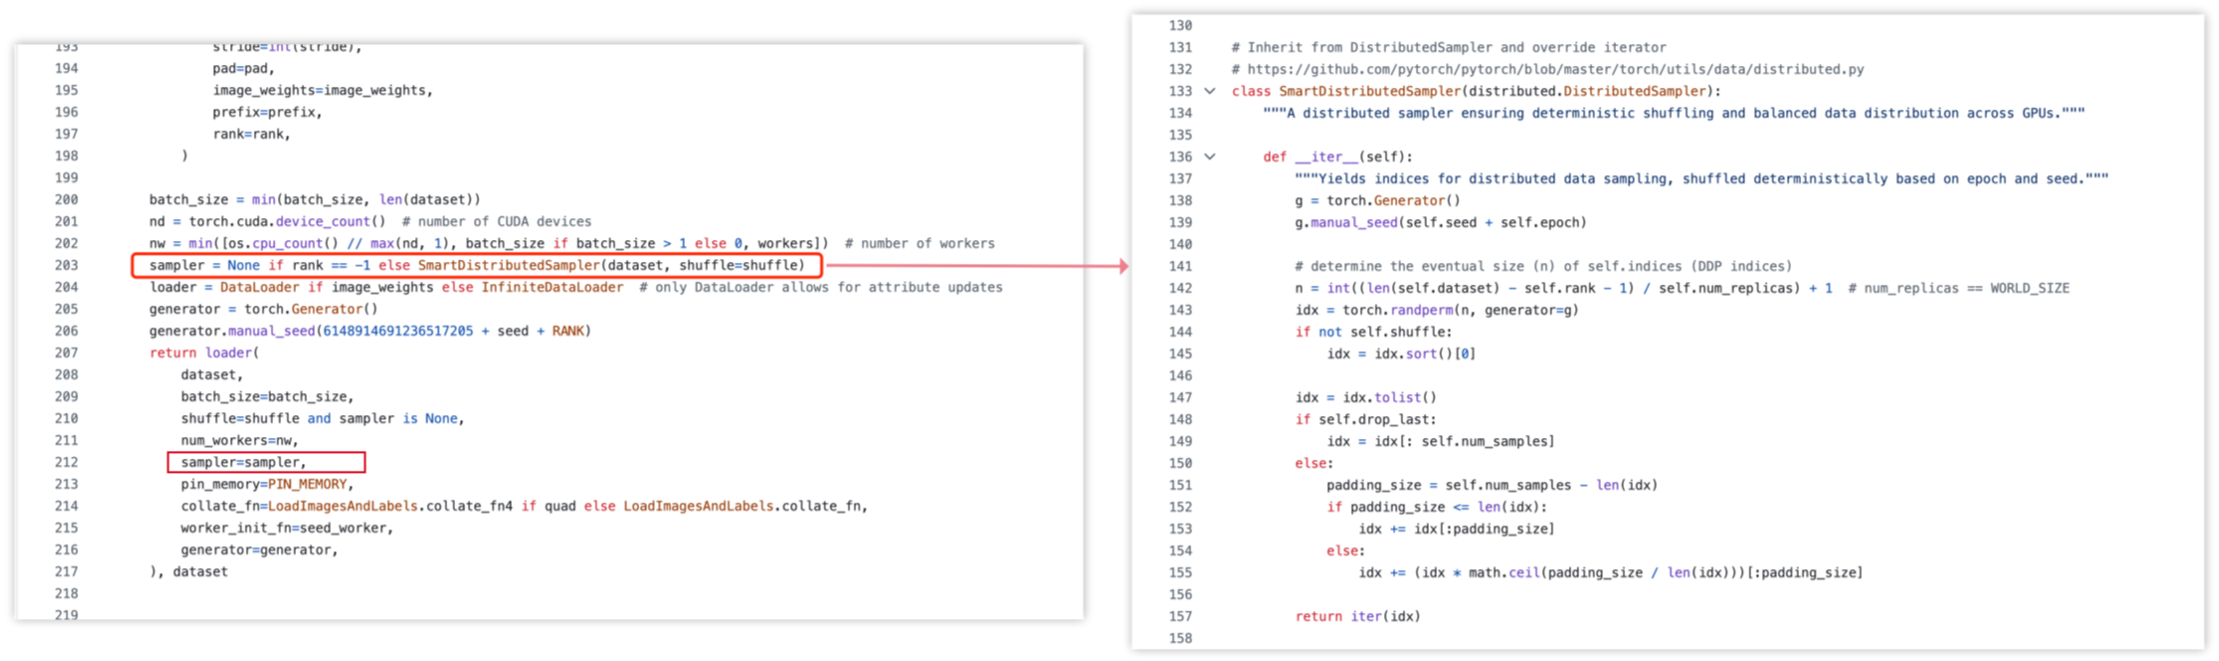

参数 sampler 有一部分功能，是和 参数 shuffle 是重叠的：
- SequentialSampler 效果等价于 shuffle=False
- RandomSampler 效果等价于 shuffle=Ture
Pytorch 提供 sampler 参数，主要是为提升灵活性，支持用户更灵活地设计数据加载的方式


1）顺序采样 SequentialSampler

作用 ：接收一个 Dataset 对象，输出数据包中样本量的顺序索引

```python
import torch.utils.data.sampler as sampler

data = list([17, 22, 3, 41, 8])
seq_sampler = sampler.SequentialSampler(data_source=data)

for index in seq_sampler:
    print("index: {}".format(index))
```

<style>
    img{
        width:20%;
        padding-left: 5%;
    }
</style>

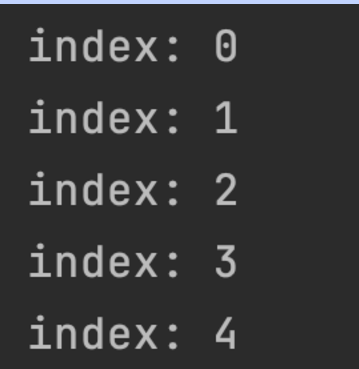

**源码**

```python
class SequentialSampler(Sampler):
    data_source: Sized

    def __init__(self, data_source: Sized) -> None:
        self.data_source = data_source

    def __iter__(self) -> Iterator[int]:
        return iter(range(len(self.data_source)))

    def __len__(self) -> int:
        return len(self.data_source)
```

- __init__  接收参数：Dataset 对象
- __iter__ 返回一个可迭代对象（返回的是索引值），因为 SequentialSampler 是顺序采样，所以返回的索引是顺序数值序列
- __len__  返回 dataset 中数据个数

举例2：

```python
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler


class myDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# 示例数据 ：0 到 19 的整数
data = [i for i in range(20)]
dataset = myDataset(data)

# 使用 SequentialSampler
sampler = SequentialSampler(dataset)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=8, sampler=sampler)

# 使用 DataLoader 迭代数据
for data in dataloader:
    print(data)

```

<style>
    img{
        width: 60%;
    }
</style>

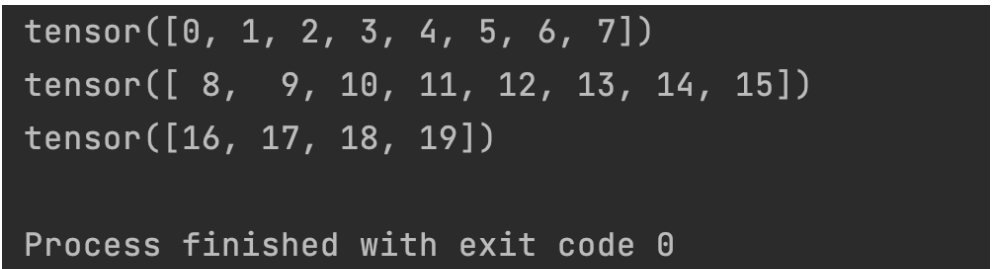

2）随机采样 RandomSampler

作用 ：接收一个 Dataset 对象，输出数据包中样本量的随机索引 （可指定是否可重复）。

举例1：

```python
import torch.utils.data.sampler as sampler

data = list([17, 22, 3, 41, 8])
seq_sampler = sampler.RandomSampler(data_source=data)

for index in seq_sampler:
    print("index: {}".format(index))
```

<style>
    img{
        width:20%;
        padding-left: 5%;
    }
</style>

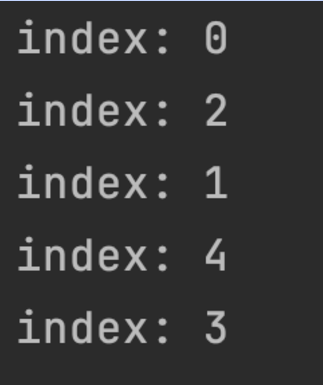

**源码**

```python
class RandomSampler(Sampler):
    def __init__(self, data_source, replacement=False, num_samples=None):
        self.data_source = data_source
        self.replacement = replacement
        self._num_samples = num_samples
        
    def num_samples(self):
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples
    
    def __len__(self):
        return self.num_samples
               
    def __iter__(self):
        n = len(self.data_source)
        if self.replacement:
            # 生成的随机数是可能重复的
            return iter(torch.randint(high=n, size=(self.num_samples,), dtype=torch.int64).tolist())
        # 生成的随机数是不重复的
        return iter(torch.randperm(n).tolist())
```

查看 torch.randperm() 的使用 ： 
- __init__ 参数 ：
- data_source (Dataset): 采样的 Dataset 对象
- replacement (bool): 如果为 True，则抽取的样本是有放回的。默认为 False
- num_samples (int):  抽取样本的数量，默认是len(dataset)。当 replacement 是 True 时，应被实例化
- __iter__ 返回一个可迭代对象（返回的是索引），因为 RandomSampler 是随机采样，所以返回的索引是随机的数值序列 （当 replacement=False 时，生成的排列是无重复的）
- __len__  返回 dataset 中样本量

举例2：

```python
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import RandomSampler


class myDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# 示例数据 ：0 到 19 的整数
data = [i for i in range(20)]
dataset = myDataset(data)

# 使用 SequentialSampler
sampler = RandomSampler(dataset)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=8, sampler=sampler)

# 使用 DataLoader 迭代数据
for data in dataloader:
    print(data)
```

<style>
    img{
        width: 50%;
    }
</style>

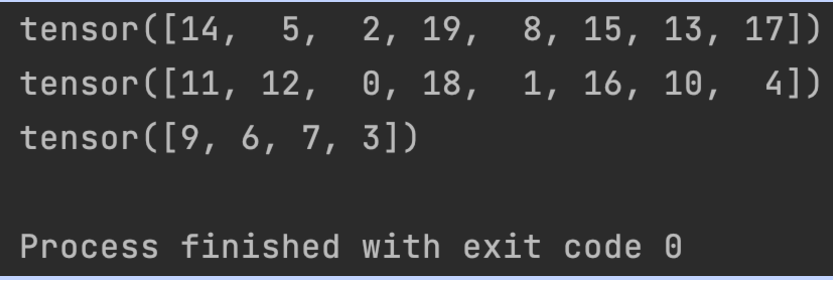



##### 2、sampler 与 shuffle 的互斥
  - 参数 sampler 与 参数 shuffle 是互斥的，不要同时使用 sampler 和  shuffle
  - 因为 shuffle 的默认值为 False，所以代码会兼容 shuffle 等于默认值 False 的情况，即 ：
    - 当同时设置了 shuffle 与 sampler，且 shuffle=True，会报错
    - 当同时设置了 shuffle 与 sampler，且 shuffle=False，具体逻辑按照 sampler
  


##### 3、批采样 BatchSampler

torch.utils.data.DataLoaderde 的参数 batch_sample， 接收的一般是 torch.utils.data.BatchSampler 对象，

torch.utils.data.BatchSampler 的作用 ： 包装另一个采样器，生成一个小批量索引采样器

举例1：

```python
import torch.utils.data.sampler as sampler
data = list([17, 22, 3, 41, 8])

seq_sampler = sampler.SequentialSampler(data_source=data)
batch_sampler = sampler.BatchSampler(seq_sampler, 2, False )

for index in batch_sampler:
    print(index)

```

<style>
    img{
        width: 15%;
    }
</style>

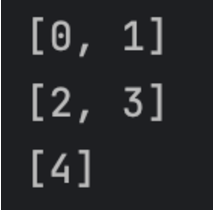

**源码**

```python
class BatchSampler(Sampler):
    def __init__(self, sampler, batch_size, drop_last):、
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last
        
    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)
            # 如果采样个数和batch_size相等则本次采样完成
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        # for 结束后在不需要剔除不足batch_size的采样个数时返回当前batch        
        if len(batch) > 0 and not self.drop_last:
            yield batch
            
    def __len__(self):
        # 在不进行剔除时，数据的长度就是采样器索引的长度
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size
```

- 参数 ：
  - sampler : 其他采样器实例
  - batch_size ：批量大小
  - drop_last ：为 “True”时，如果最后一个batch 采样得到的数据个数小于batch_size，则抛弃最后一个batch的数据

举例2：

```python
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, BatchSampler


class myDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# 示例数据 ：# 生成 0 到 19 的整数
data = [i for i in range(20)]
dataset = myDataset(data)

# 使用 SequentialSampler 顺序采样
sequential_sampler = SequentialSampler(dataset)

# 使用 BatchSampler 将 SequentialSampler 和 batch_size 结合
batch_sampler = BatchSampler(sequential_sampler, batch_size=8, drop_last=False)

# 创建 DataLoader，使用 BatchSampler
dataloader = DataLoader(dataset, batch_sampler=batch_sampler)

# 使用 DataLoader 迭代数据
for data in dataloader:
    print(data)
```

##### 4、BatchSampler 与 其他参数的互斥

如果你在 DataLoader(dataset, batch_sampler=batch_sampler) 中指定了参数 batch_sampler， 那么就不能再指定参数 batch_size、shuffle、sampler、和 drop_last 了，他们互斥。

因为：
- 你在生成torch.utils.data.sampler.BatchSampler() 的时候，就已经制定过  batch_size、sampler、和 drop_last 这些参数了，
- batch_sampler 与 shuffle 作用一致，所以也互斥

### 重写 collate_fn 实例



#### 1、collate_fn 函数作用

在使用  torch.utils.data.dataset 时，参数 `collate_fn` 接受一个函数，该函数的函数名通常就定义为： collate_fn

`collate_fn` 函数的作用 ：将多个经过 `dataset.getitem()` 处理好的 样本数据，组合成一个 batch 的数据。

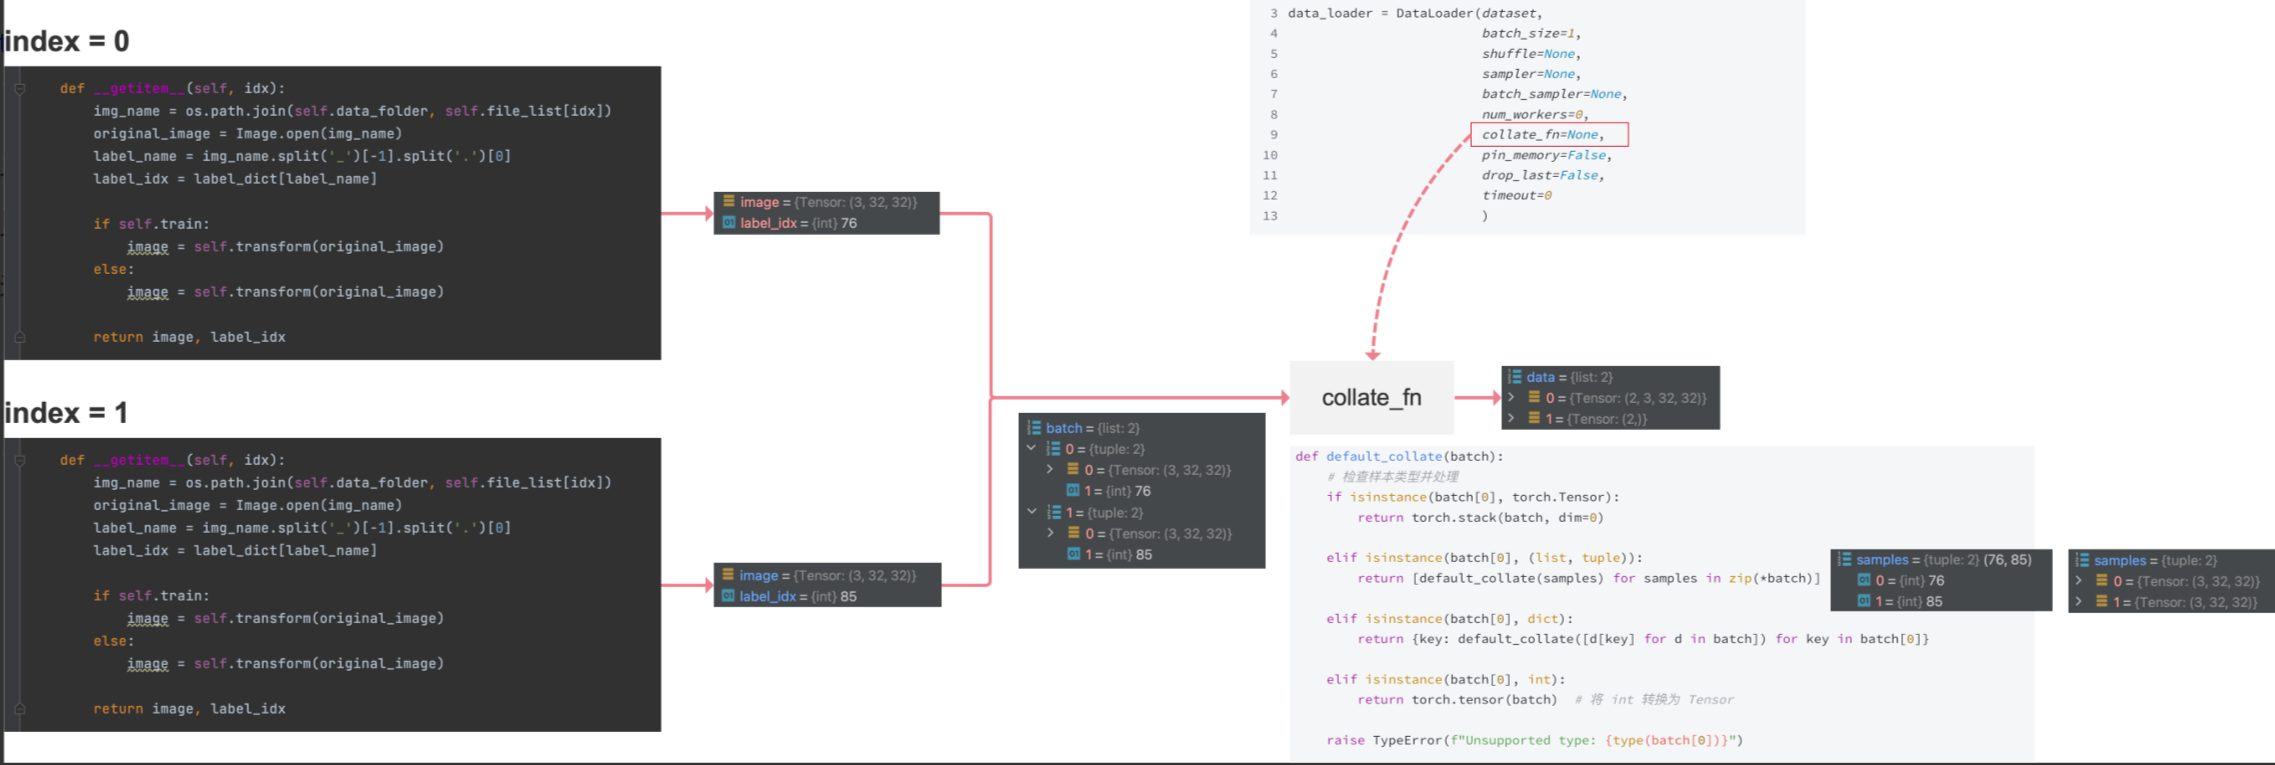

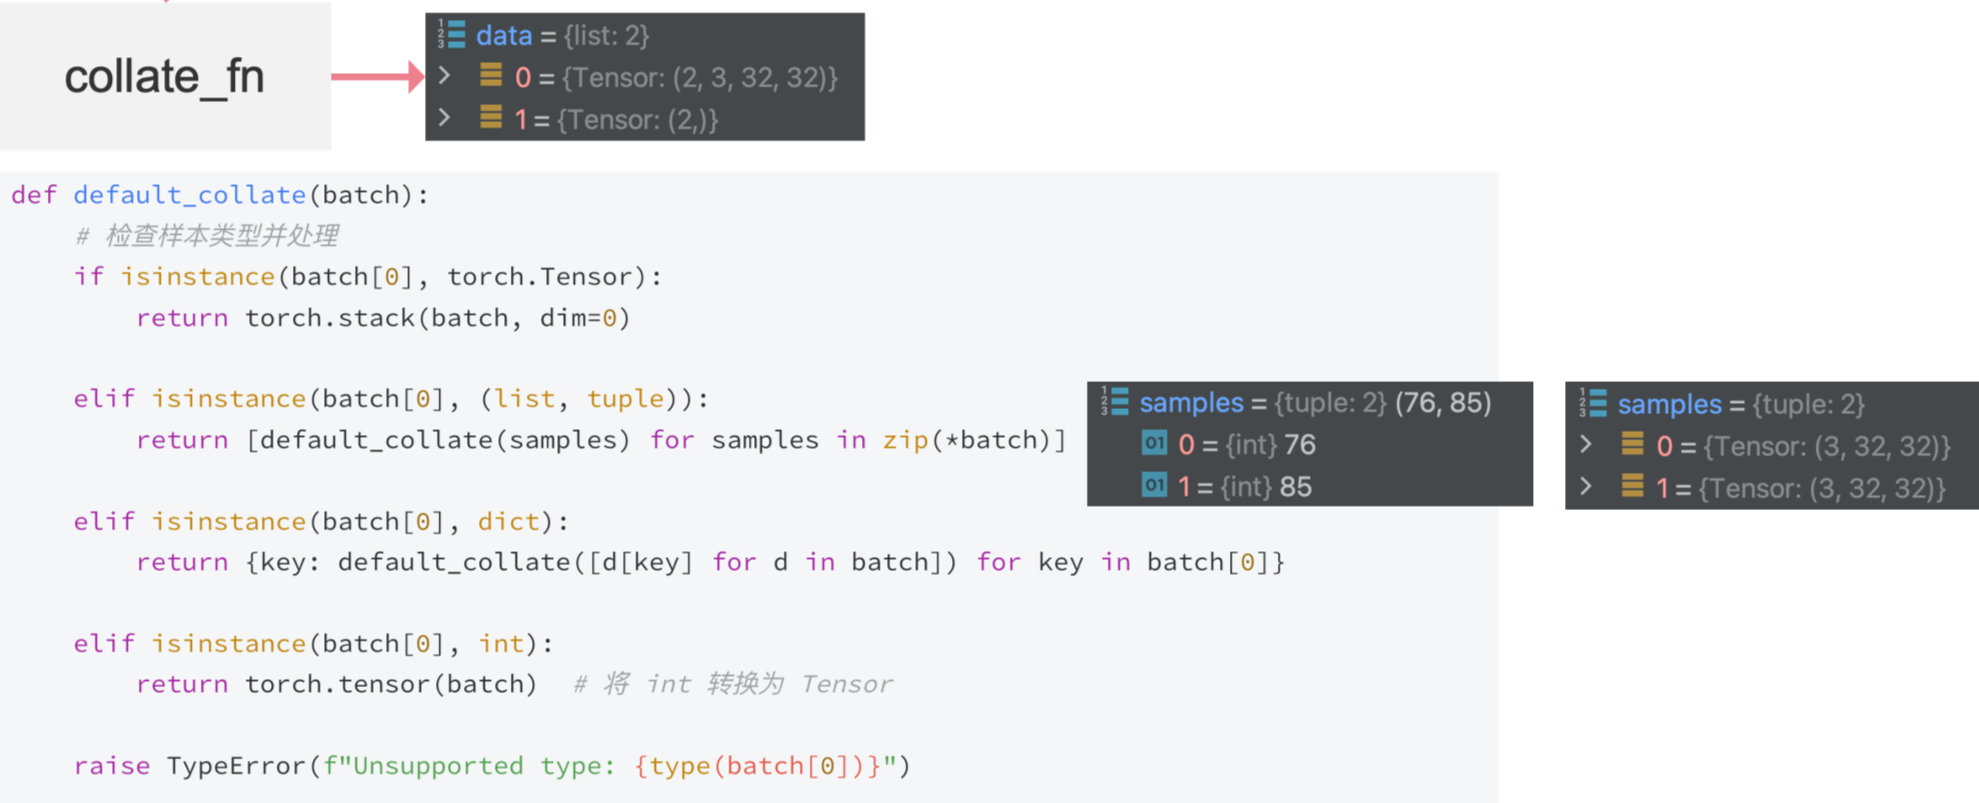

#### 2、默认 collate_fn 函数

```python
def default_collate(batch):
    # 检查样本类型并处理
    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch, dim=0)
    
    elif isinstance(batch[0], (list, tuple)):
        return [default_collate(samples) for samples in zip(*batch)]
    
    elif isinstance(batch[0], dict):
        return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
    
    elif isinstance(batch[0], int):
        return torch.tensor(batch)  # 将 int 转换为 Tensor
    
    raise TypeError(f"Unsupported type: {type(batch[0])}")
```

#### 3、自定义 collate_fn 函数

##### 1）常见场景
举例 ：一个 batch 中的 多张图片，经过 dataset.getitem() 方法，得到的图像输出尺寸不一样  （比如，可能因为 图像增强 使用 的 transforms ，设计的 最后一步处理方式是范围内的随机裁剪）

因为 网络要求输入数据的尺寸形式为 （batch_size， channel， high，width）， 为了将多张图像数据打包成一个batch 的数据形式，需要将图像加上padding，保证所有图像尺寸一致，进而组成 batch 的数据形式 

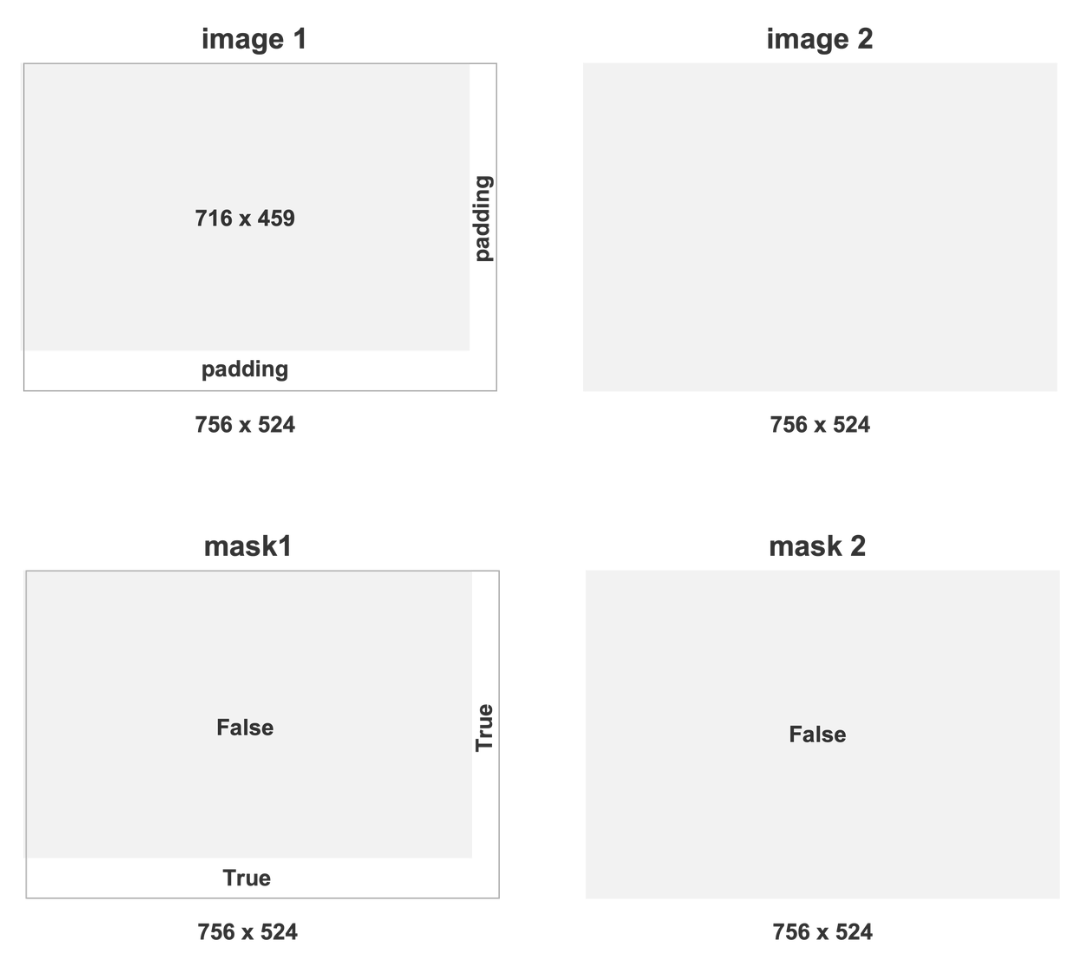

collate_fn 函数中需要处理的内容为 ：
  - 对比 batch 中，所有图像的宽和高，找到最长的宽度 和 最长的高度
  - 将所有的图像都 padding 到最长的宽度 和 最长的高度
  - 处理的得到 mask 数据，用于标注 ： 哪些位置是 有效像素，哪些位置是 padding
  - 将所有数据处理成 batch 的格式，进行返回

##### 2）相关代码实现

```python
data_loader_train = DataLoader(dataset_train, 
                               batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn, 
                               num_workers=args.num_workers,
                               pin_memory=True)
                               
data_loader_val = DataLoader(dataset_val, 
                             args.batch_size, 
                             sampler=sampler_val,
                             drop_last=False, 
                             collate_fn=utils.collate_fn, 
                             num_workers=args.num_workers,
                             pin_memory=True)
```

```python
def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False
    else:
        raise ValueError('not supported')
    return NestedTensor(tensor, mask)
```

#### 4、附

注 ：更换 cifar-100 在你本地的路径


```python
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


torch.manual_seed(121)
torch.cuda.manual_seed(121)

label_dict = {
    'apple': 0,
    'aquarium_fish': 1,
    'baby': 2,
    'bear': 3,
    'beaver': 4,
    'bed': 5,
    'bee': 6,
    'beetle': 7,
    'bicycle': 8,
    'bottle': 9,
    'bowl': 10,
    'boy': 11,
    'bridge': 12,
    'bus': 13,
    'butterfly': 14,
    'camel': 15,
    'can': 16,
    'castle': 17,
    'caterpillar': 18,
    'cattle': 19,
    'chair': 20,
    'chimpanzee': 21,
    'clock': 22,
    'cloud': 23,
    'cockroach': 24,
    'couch': 25,
    'crab': 26,
    'crocodile': 27,
    'cup': 28,
    'dinosaur': 29,
    'dolphin': 30,
    'elephant': 31,
    'flatfish': 32,
    'forest': 33,
    'fox': 34,
    'girl': 35,
    'hamster': 36,
    'house': 37,
    'kangaroo': 38,
    'keyboard': 39,
    'lamp': 40,
    'lawn_mower': 41,
    'leopard': 42,
    'lion': 43,
    'lizard': 44,
    'lobster': 45,
    'man': 46,
    'maple_tree': 47,
    'motorcycle': 48,
    'mountain': 49,
    'mouse': 50,
    'mushroom': 51,
    'oak_tree': 52,
    'orange': 53,
    'orchid': 54,
    'otter': 55,
    'palm_tree': 56,
    'pear': 57,
    'pickup_truck': 58,
    'pine_tree': 59,
    'plain': 60,
    'plate': 61,
    'poppy': 62,
    'porcupine': 63,
    'possum': 64,
    'rabbit': 65,
    'raccoon': 66,
    'ray': 67,
    'road': 68,
    'rocket': 69,
    'rose': 70,
    'sea': 71,
    'seal': 72,
    'shark': 73,
    'shrew': 74,
    'skunk': 75,
    'skyscraper': 76,
    'snail': 77,
    'snake': 78,
    'spider': 79,
    'squirrel': 80,
    'streetcar': 81,
    'sunflower': 82,
    'sweet_pepper': 83,
    'table': 84,
    'tank': 85,
    'telephone': 86,
    'television': 87,
    'tiger': 88,
    'tractor': 89,
    'train': 90,
    'trout': 91,
    'tulip': 92,
    'turtle': 93,
    'wardrobe': 94,
    'whale': 95,
    'willow_tree': 96,
    'wolf': 97,
    'woman': 98,
    'worm': 99
}


def default_collate(batch):
    # 检查样本类型并处理
    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch, dim=0)

    elif isinstance(batch[0], (list, tuple)):
        return [default_collate(samples) for samples in zip(*batch)]

    elif isinstance(batch[0], dict):
        return {key: default_collate([d[key] for d in batch]) for key in batch[0]}

    elif isinstance(batch[0], int):
        return torch.tensor(batch)  # 将 int 转换为 Tensor

    raise TypeError(f"Unsupported type: {type(batch[0])}")


class CustomDataset(Dataset):
    def __init__(self, data_folder, train, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.file_list = os.listdir(data_folder)
        self.train = train

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.file_list[idx])
        original_image = Image.open(img_name)
        label_name = img_name.split('_')[-1].split('.')[0]
        label_idx = label_dict[label_name]

        if self.train:
            image = self.transform(original_image)
        else:
            image = self.transform(original_image)

        return image, label_idx

    def __len__(self):
        return len(self.file_list)


images_dir = "/Users/enzo/Documents/GitHub/dataset/CIFAR/cifar-100-images/train"
dataset = CustomDataset(images_dir, train=True, transform=transforms.ToTensor())

data_loader = DataLoader(dataset,
                         batch_size=2,
                         shuffle=True,
                         collate_fn=default_collate)


for data in data_loader:
    image, label = data

```

## 数据处理&数据增强

## 网络搭建

### nn.Module 与 nn.functional

### 卷积神经网络

### 网络容器

#### 1. Sequential

#### 2. ModuleList

#### 3. ModuleDict

### torchvision.models 模块

### 参数初始化

### register_buffer、register_parameter

### 查看网络的层/层名

### 查看网络参数

### 查看网络结构的4种方法

### 网络操作

#### 对网络的层进行增、删、改

#### 获取模型中间层的输出

#### 模型/参数 的保存与加载



打印网络信息：

- 
```python
print(net)
```

- 
```python
print(torchinfo.summary(net, input_size=(3, 224, 224)))
```

In [3]:
import torch.nn as nn
from collections import OrderedDict
from typing import Any, Callable, Dict, Optional, Tuple, TypeVar, Union


class IntermediateLayerGetter(nn.ModuleDict):
    """
    Module wrapper that returns intermediate layers from a model

    It has a strong assumption that the modules have been registered
    into the model in the same order as they are used.
    This means that one should **not** reuse the same nn.Module
    twice in the forward if you want this to work.

    Additionally, it is only able to query submodules that are directly
    assigned to the model. So if `model` is passed, `model.feature1` can
    be returned, but not `model.feature1.layer2`.

    Args:
        model (nn.Module): model on which we will extract the features
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).

    Examples::

        >>> m = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        >>> # extract layer1 and layer3, giving as names `feat1` and feat2`
        >>> new_m = torchvision.models._utils.IntermediateLayerGetter(m,
        >>>     {'layer1': 'feat1', 'layer3': 'feat2'})
        >>> out = new_m(torch.rand(1, 3, 224, 224))
        >>> print([(k, v.shape) for k, v in out.items()])
        >>>     [('feat1', torch.Size([1, 64, 56, 56])),
        >>>      ('feat2', torch.Size([1, 256, 14, 14]))]
    """

    _version = 2
    __annotations__ = {
        "return_layers": Dict[str, str],
    }

    def __init__(self, model: nn.Module, return_layers: Dict[str, str]) -> None:
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super().__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

In [2]:
import torch
import torchvision.models as models
from torchvision.models._utils import IntermediateLayerGetter

## 激活函数

## 网络模式train()和eval()

## 优化器与学习率

## 损失函数

## 评价指标

1. **图像分类**：
   - 准确率（Accuracy）：分类正确的样本占总样本的比例。
   - 精确率（Precision）：预测为正的样本中实际为正的比例。
   - 召回率（Recall）：实际为正的样本中被预测为正的比例。
   - F1分数（F1 Score）：精确率和召回率的调和平均值，适用于类别不平衡的情况。
   - 混淆矩阵（Confusion Matrix）：显示每个类别预测正确的数量和错误的数量。

2. **目标检测**：
   - 平均精度（mAP）：在不同IoU（交并比）阈值下的精度的平均值，是目标检测任务中最常用的指标。
   - 交并比（IoU）：预测框与真实框的交集区域面积比上它们的并集区域面积，用于衡量预测框与真实框的重叠程度。
   - 平均重叠度（Average Overlap）：预测框与真实框的平均交并比。

3. **语义分割**：
   - 像素准确率（Pixel Accuracy）：预测正确的像素数占总像素的比例。
   - 均值IoU（Mean IoU）：对于每个类别，计算预测区域与真实区域的IoU，再取平均值。
   - Dice系数：预测区域与真实区域的交集面积的两倍比上预测区域与真实区域的面积之和，常用于医学图像分割任务。

4. **实例分割**：
   - 平均精度（mAP）：类似于目标检测中的mAP，但考虑了分割的准确性。
   - 平均Dice系数（Mean Dice Score）：对于每个实例，计算Dice系数，再取平均值。
   - 平均重叠度（Mean Overlap）：类似于目标检测中的平均交并比，但用于衡量实例分割的效果。

5. **面部识别**：
   - 认真率（True Acceptance Rate, TAR）：在一定的误识率条件下，系统正确识别出相同人脸的比例。
   - 误识率（False Rejection Rate, FRR）：在一定的认认真率条件下，系统错误地拒绝相同人脸的比例。
   - 验证准确率（Verification Accuracy）：系统正确识别出相同或不同人脸的准确率。

6. **姿态估计**：
   - 关键点检测误差（Keypoint Detection Error）：预测关键点与真实关键点之间的距离。
   - 平均角度误差（Average Angular Error）：预测姿态与真实姿态之间的角度差异。

1. **准确率（Accuracy）**：
   - 定义：准确率是分类正确的样本数占总样本数的比例，它衡量的是模型整体预测的正确性。
   - 计算公式：准确率 = (真阳性 + 真阴性) / (真阳性 + 假阳性 + 真阴性 + 假阴性)

2. **精确率（Precision）**：
   - 定义：精确率是指预测为正的样本中实际为正的比例，它关注的是模型在预测为正时的正确程度。
   - 计算公式：精确率 = 真阳性 / (真阳性 + 假阳性)

3. **召回率（Recall）**：
   - 定义：召回率是指实际为正的样本中被正确预测为正的比例，它关注的是模型发现所有正样本的能力。
   - 计算公式：召回率 = 真阳性 / (真阳性 + 假阴性)

**关系**：
- 准确率适用于类别分布均匀的情况。如果类别分布不均匀，比如一个类别占绝大多数，那么即使模型对少数类别的识别很差，也可能有一个很高的准确率。
- 精确率和召回率在类别不平衡的情况下更加有效。例如，在一个二分类问题中，如果正样本很少，即使模型的准确率很高，也可能忽视了正样本的预测。
- 精确率和召回率通常会有一个权衡关系，即提高一个指标可能会降低另一个指标。例如，如果降低分类的阈值，可能会增加精确率，但同时降低召回率。
- 另一个常用的结合了精确率和召回率的指标是F1分数，它是精确率和召回率的调和平均值，公式为：F1分数 = 2 * (精确率 * 召回率) / (精确率 + 召回率)

这些指标需要根据具体的应用场景来选择使用。有时，需要根据业务需求调整精确率和召回率的平衡点。

## 训练日志

## 训练代码框架

## 训练策略

## 其他

### 插值算法

### IOU (Intersection over Union)

### NMS (Non-Maxima Suppression)

## 目标检测算法
### anchor-based相关算法
1. 针对 feature-map 上的每一个像素，都预测出 n 个anchor，这 n个 anchor 的尺寸/高宽比 是我们人工预期定义好的。
2. 网络基于这些 anchor，去预测他们的类别，中心点偏移量、高宽缩放因子，得到网络预测结果，
    这时候的预测bbox 的数量为 ： $w \times h \times n$ ，其中，w 和 h 是 feature map 的宽 和 高，n 是 anchor 的 (不同尺寸的) 数量
3. 再根据类别置信度 和 NMS，筛选出最终的预测结果。

### 